# Grupo Caça-Fome

GUILHERME HENRIQUE MELO DE OLIVEIRA – RM: 95184

GUILHERME LUCAS ARTIGIANI – RM: 94322

VINICIUS GONÇALVES CARNEIRO – RM: 94154


## Importando bibliotecas

In [60]:
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import cv2
import os

import tensorflow as tf 
import keras 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator

## Começando o treinamento

In [156]:
# Lendo tabela com dados nutricionais dos alimentos utilizados para o treinamento e importanto como dataframe
tabela_nutricional = pd.read_excel(r'C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\ficha_alimentos.xlsx')
tabela_nutricional

,Alimento,Quantidade (g),Calorias,Gorduras Totais (g),Colesterol (mg),Sodio (mg),Potassio (mg),Carboidratos (g),Proteinas (g)
0,Torta de maca,100.0,237,11.0,0,266,65,34.0,1.9
1,Batata Frita,100.0,312,15.0,0,210,579,41.0,3.4
2,Arroz,100.0,130,0.3,0,1,35,28.0,2.7
3,Hamburger,100.0,295,14.0,47,414,226,24.0,17.0
4,Hot-dog,100.0,290,26.0,77,1090,152,4.2,10.0
5,Minimo diario,NaN,2000,70.0,300,2300,4700,130.0,50.0


In [61]:
# Carregando as pastas com as imagens
pasta_torta_de_maca = r"C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\train\torta_maca"
pasta_batata_frita = r"C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\train\batata-frita"
pasta_arroz = r"C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\train\arroz"
pasta_hamburger = r"C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\train\hamburger"
pasta_hot_dog = r"C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\train\hot_dog"

# Listando as imagens dos diretorios, nas listas criadas
arqs_torta_de_maca = os.listdir(pasta_torta_de_maca)
arqs_batata = os.listdir(pasta_batata_frita)
arqs_arroz = os.listdir(pasta_arroz)
arqs_hamburger = os.listdir(pasta_hamburger)
arqs_hot_dog = os.listdir(pasta_hot_dog)

X = []

In [62]:
# Caminho completo do arquivo, pasta + nome do arquivo
for fname in arqs_torta_de_maca:
    X.append([os.path.join(pasta_torta_de_maca,fname),0])
for fname in arqs_batata:
    X.append([os.path.join(pasta_batata_frita,fname),1])
for fname in arqs_arroz:
    X.append([os.path.join(pasta_arroz,fname),2])
for fname in arqs_hamburger:
    X.append([os.path.join(pasta_hamburger,fname),3]) 
for fname in arqs_hot_dog:
    X.append([os.path.join(pasta_hot_dog,fname),4])  
X = pd.DataFrame(X,columns = ['pasta','labels'])    

In [63]:
X.head()

,pasta,labels
0,C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TD...,0
1,C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TD...,0
2,C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TD...,0
3,C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TD...,0
4,C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TD...,0


In [64]:
# Tecnica para tratamento dos dados categoricos
ohencoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohlabel = pd.DataFrame(ohencoder.fit_transform(X[['labels']]),dtype = 'float64',columns = ['label0','label1','label2','label3','label4'])
label_X = X.copy()
X = pd.concat([X,ohlabel],axis = 1)
new_X = X.drop(['labels'],axis = 1)

c:\Users\guiol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [65]:
# Separando conjunto de treino e teste, 80% / 20%
train,test = train_test_split(new_X,test_size=0.2,random_state=32,shuffle = True)

In [66]:
# Dividindo conjunto de dados em X e y, recursos e rotulos
X_train = train['pasta'].values
y_train = train.drop(['pasta'],axis=1).values
X_test = test['pasta'].values
y_test = test.drop(['pasta'],axis=1).values

In [67]:
# Função para pré processamento das imagens 
def deep_pipeline(data):
    flat = []
    for i in data:
        img = cv2.imread(i)
        img = cv2.resize(img, (224,224))
        img = img/255
        flat.append(img)
    flat =  np.array(flat)    
    flat = flat.reshape(-1,224,224,3)
    return flat


In [68]:
dx_train = deep_pipeline(X_train)
dx_test = deep_pipeline(X_test)

In [69]:
# Criando e configurando modelo de rede neural, VGG19, 
vgg = keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg.trainable = False

# Criando um modelo sequencial do Keras, que é uma pilha linear de campeonatos
vggmodel = keras.Sequential([vgg
                         ,Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(1000,activation='tanh'),Dense(5,activation='softmax')])

vggmodel.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_12 (Dense)            (None, 1000)              513000    
                                                                 
 dense_13 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_15 (Dense)            (None, 5)                 5005      
                                                                 
Total params: 22,544,389
Trainable params: 2,520,005
Non-trainable params: 20,024,384
_________________________________________________________________


In [70]:
hist = vggmodel.fit(dx_train,y_train,epochs=50,validation_split=0.3,batch_size=16)

Epoch 1/50
80/80 [==============================] - 275s 3s/step - loss: 1.7090 - accuracy: 0.4757 - val_loss: 1.0900 - val_accuracy: 0.5036
Epoch 2/50
80/80 [==============================] - 299s 4s/step - loss: 0.9974 - accuracy: 0.5823 - val_loss: 1.0592 - val_accuracy: 0.5420
Epoch 3/50
80/80 [==============================] - 331s 4s/step - loss: 0.9011 - accuracy: 0.5987 - val_loss: 1.3634 - val_accuracy: 0.4672
Epoch 4/50
80/80 [==============================] - 341s 4s/step - loss: 0.8267 - accuracy: 0.6293 - val_loss: 0.9350 - val_accuracy: 0.6150
Epoch 5/50
80/80 [==============================] - 342s 4s/step - loss: 0.8674 - accuracy: 0.6207 - val_loss: 1.1687 - val_accuracy: 0.5657
Epoch 6/50
80/80 [==============================] - 348s 4s/step - loss: 0.7480 - accuracy: 0.6591 - val_loss: 0.8268 - val_accuracy: 0.6350
Epoch 7/50
80/80 [==============================] - 347s 4s/step - loss: 0.7117 - accuracy: 0.6763 - val_loss: 0.8372 - val_accuracy: 0.6478
Epoch 8/50
80

In [71]:
# Avaliando modelo
score = vggmodel.evaluate(dx_test,y_test)
print("Auracia: ", score[1])

15/15 [==============================] - 87s 6s/step - loss: 1.3224 - accuracy: 0.6250
Auracia:  0.625


In [72]:
pred = vggmodel.predict(dx_test)
prediction = np.argmax(pred,axis=1)
true = np.argmax(y_test,axis=1)
melhor_prob = [pred[num,:][i] for num,i in enumerate(prediction)]

15/15 [==============================] - 85s 6s/step


In [140]:
# Função criada para pegar uma imagem e passar no modelo treindo, verificando a classificação e a acuracia.
def deepmodelpipeline(qtde, imagepath,model = vggmodel,label=[-1]):
    pdict = {0:"Torta de maca",1:"Batata Frita",2:"Arroz",3:"Hamburger",4:"Hot-dog"}
    pred_x = deep_pipeline([imagepath])
    prediction = model.predict(pred_x)
    pred = np.argmax(prediction[0])
    # plt.imshow(plt.imread(imagepath))
    accuracy = prediction[0, pred] * 100
    classification = pdict[pred]
    image = plt.imread(imagepath)

    if (label[0]!=-1):
        plt.title("Predição : {0} % {1:.2f} \ntrue        : {2}".format(pdict[pred],prediction[0,pred]*100,pdict[np.argmax(label)]))
    else:
        plt.title("Predição : {0}, % {1:.2f}".format(pdict[pred],prediction[0,pred]*100))

    # Aqui estamos pegando os valores nutricionais e calculando com base na quantidade de alimento doada
    linha = tabela_nutricional.loc[tabela_nutricional['Alimento'] == classification].copy()
    for c in linha.columns:
        if c != "Alimento":
            linha.loc[:, c] = linha.loc[:, c] * qtde
    linha.insert(1, 'Qtde doada', qtde)

    return image, classification, accuracy, linha

## Testes:

Testando Arroz

In [159]:
foto_da_doacao = r'C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\test\arroz\117028.jpg'
opcao_doacao = int(input("Para podermos calcular o valor nutricional e encaminhar para locais mais necessitados, pedimos que nos diga a quantidade que pretende doar do alimento enviado na foto acima: "))

1/1 [==============================] - 0s 136ms/step


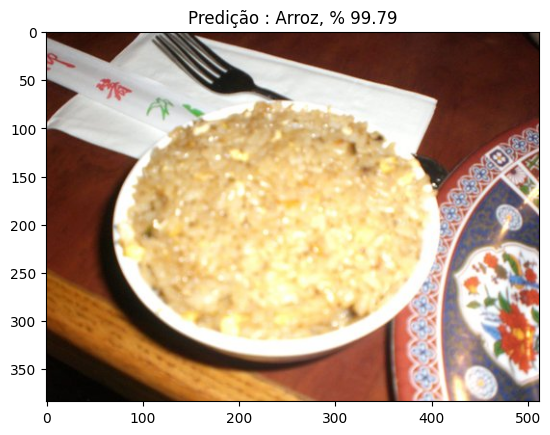

,Alimento,Qtde doada,Quantidade (g),Calorias,Gorduras Totais (g),Colesterol (mg),Sodio (mg),Potassio (mg),Carboidratos (g),Proteinas (g)
2,Arroz,4,400.0,520,1.2,0,4,140,112.0,10.8


**************************************************
               Classificação: Arroz               
                 Acurácia: 99.79%                 
**************************************************


In [160]:
image, classification, accuracy, linha = deepmodelpipeline(opcao_doacao, foto_da_doacao)
plt.imshow(image)
plt.show()
display(linha)
print("*" * 50)
print("{:^50}".format("Classificação: {}".format(classification)))
print("{:^50}".format("Acurácia: {:.2f}%".format(accuracy)))
print("*" * 50)

Testando Batata frita

In [161]:
foto_da_doacao = r'C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\test\batata_frita\100148.jpg'
opcao_doacao = int(input("Para podermos calcular o valor nutricional e encaminhar para locais mais necessitados, pedimos que nos diga a quantidade que pretende doar do alimento enviado na foto acima: "))

1/1 [==============================] - 0s 139ms/step


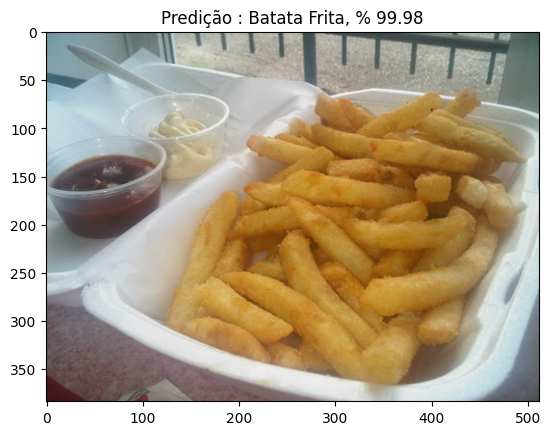

,Alimento,Qtde doada,Quantidade (g),Calorias,Gorduras Totais (g),Colesterol (mg),Sodio (mg),Potassio (mg),Carboidratos (g),Proteinas (g)
1,Batata Frita,4,400.0,1248,60.0,0,840,2316,164.0,13.6


**************************************************
           Classificação: Batata Frita            
                 Acurácia: 99.98%                 
**************************************************


In [155]:
foto_da_doacao = r'C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\test\batata_frita\100148.jpg'

image, classification, accuracy, linha = deepmodelpipeline(opcao_doacao, foto_da_doacao)
plt.imshow(image)
plt.show()
display(linha)
print("*" * 50)
print("{:^50}".format("Classificação: {}".format(classification)))
print("{:^50}".format("Acurácia: {:.2f}%".format(accuracy)))
print("*" * 50)


Testando Torta de maça

In [157]:
foto_da_doacao = r'C:\Users\guiol\Documents\Estudos\FIAP\FIAP-2TDST\DISRUPTIVE_ARCHITECTURES-IT_IOB-IA\Teste_gs\test\torta_maca\222074.jpg'
opcao_doacao = int(input("Para podermos calcular o valor nutricional e encaminhar para locais mais necessitados, pedimos que nos diga a quantidade que pretende doar do alimento enviado na foto acima: "))

1/1 [==============================] - 0s 135ms/step


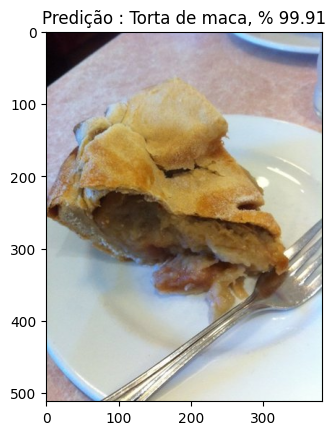

,Alimento,Qtde doada,Quantidade (g),Calorias,Gorduras Totais (g),Colesterol (mg),Sodio (mg),Potassio (mg),Carboidratos (g),Proteinas (g)
0,Torta de maca,6,600.0,1422,66.0,0,1596,390,204.0,11.4


**************************************************
           Classificação: Torta de maca           
                 Acurácia: 99.91%                 
**************************************************


In [158]:
image, classification, accuracy, linha = deepmodelpipeline(opcao_doacao, foto_da_doacao)
plt.imshow(image)
plt.show()
display(linha)
print("*" * 50)
print("{:^50}".format("Classificação: {}".format(classification)))
print("{:^50}".format("Acurácia: {:.2f}%".format(accuracy)))
print("*" * 50)
